# Лабораторная работа №1 по курсу Deep Learning 

Выполнил: **Борисов Алексей**

Задача заключается в исследовании влияния различных гиперпараметров сверточной нейронной сети (CNN) на распределение градиентов по слоям. Кроме того, необходимо исследовать связь распределения градиентов по слоям с качеством.
Гиперпараметры, которые необходимо исследовать:

* Глубина;
* Ширина;
* Использование skip-connection;
* Использование батч-нормализации (batch normalization);
* Использование дропаута (dropout);
* Способ инициализации весов модели;
* Используемый оптимизатор.

Существует огромное количество архитектур сверточных нейронных сетей, например: LeNet, VGG, ResNet, Inception. Необходимо выбрать конкретный вариант сети и уже на ней оценивать влияние гиперпараметров, варьируя их значения. Также для таких гиперпараметров как глубина и ширина необходимо уточнить, что именно под ними подразумевается.

В качестве архитектуры сверточной сети будем использовать блочную структуру, подобную той, что использовалась в статье, посвященной [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf):

<img src="./assets/EfficientNet.png" width="1000">

Глубину и ширину будем понимать как на изображении выше: глубина равна количеству сверточных слоев, а ширина соотвествует числу каналов. Менять ширину некоторой заранее фиксированной сети будем следующим образом: ширина параметризуется числом $w$, которое определяет новое число каналов в каждом промежуточном сверточном слое. Если в слое было $C_i$ каналов, то станет $w \cdot C_i$ (если полученное число не является целым, то оно округляется до ближайшего целого числа). В данной работе зафиксируем, что число каналов в каждой следующей серии блоков в 2 раза больше чем в предыдущей.

Каждый блок имеет следующий вид:
<center><b> <font size="+2">Convolution -> [BatchNorm] -> Activation -> [Dropout]</font></b></center>&nbsp;

В квадратные скобки заключены части, которые могут отсутствовать. В качестве функции активации будем использовать ReLU.

Между каждой серией блоков располагается Max-Pooling слой c ядром размера (2, 2).

## Подготовка данных

Произведем загрузку необходимых данных. К счастью датасет SVHN присутствует в PyTorch. 

In [4]:
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import DataLoader

transforms_list = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = SVHN(root='.', split='train', download=True, transform=transforms_list)
test_dataset = SVHN(root='.', split='test', download=True, transform=transforms_list)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Using downloaded and verified file: .\train_32x32.mat
Using downloaded and verified file: .\test_32x32.mat


Изобразим несколько изображений, чтобы показать, что представляют из себя данные. Под изображениями раполагается цифра, которую сеть должна распознать.

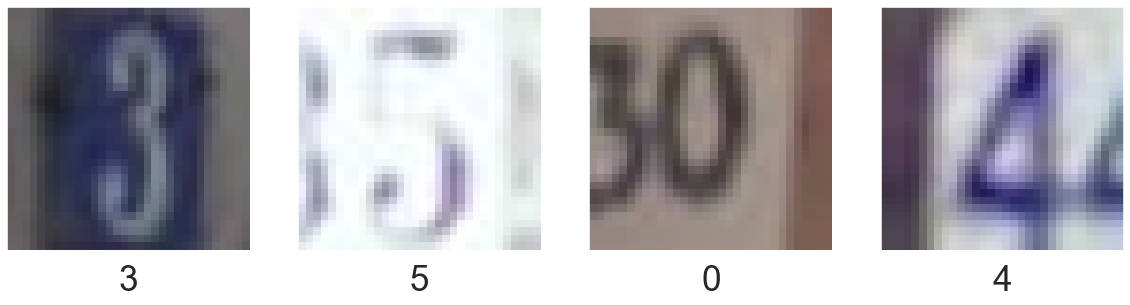

In [5]:
from lab_vis import show_samples

show_samples(train_dataset)

## Исследование зависимости распределения градиентов от каждого параметра по отдельности

Исследуем, как будет меняться распределение градиентов при варьировании каждого гиперпараметра по отдельности. 
Для того чтобы в динамике оценить, как меняется распределение градиентов во время обучения, будем визуализировать распределение градиентов на первой и последней эпохах.


Если при описании эксперимента явно не указано иного, значения параметров полагаются следующими:

* Глубина &mdash; 5;
* Ширина &mdash; 1.0;
* Использование skip-connection &mdash; нет;
* Использование батч-нормализации (batch normalization) &mdash; нет;
* Использование дропаута (dropout) &mdash; нет;
* Способ инициализации весов моделей &mdash; инициализация, которая используется в PyTorch по умолчанию, используется равномерное распределение. Значение параметров этого распределения можно посмотреть в [документации](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html);
* Используемый оптимизатор &mdash; SGD без инерции.

Для воспроизводимости результатов зафиксируем random seed. Также импортируем нужные модули.

In [6]:
import torch
import random
import numpy as np

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from torch import nn
from lab_utils import train, evaluate, get_info, init_conv_layers
from lab_models import CustomCNN, CustomCNNBlock
from lab_vis import show_layer_grads, show_hist

### Глубина

Рассмотрим следующие значения глубины: 1, 3, 5, 7, 10.

In [11]:
depths = [1, 3, 5, 7, 10]
n_epochs = 10
loss_function = nn.NLLLoss()

for d in depths:
    model = CustomCNN(depth=d, width=1.0, skip=False, dropout=0.0, batchnorm=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'depth_{d}', True, test_dataloader, True)

  0%|          | 0/10 [00:00<?, ?it/s]

Для каждого значения глубины визуализируем распределение градиентов для не более чем 4 сверточных слоев. Если слоев в модели меньше 4, то визуализируем все что есть, в противном случае равномерно по глубине выбирем 4 слоя. При исследовании остальных параметров будем действовать аналогично.

Train loss - 1.360, Test loss - 1.690
Train accuracy - 0.575, Test accuracy - 0.492



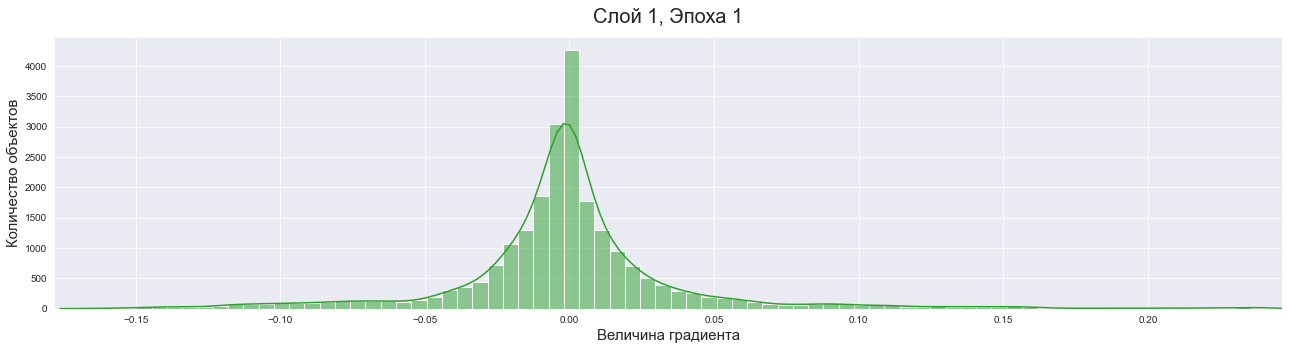

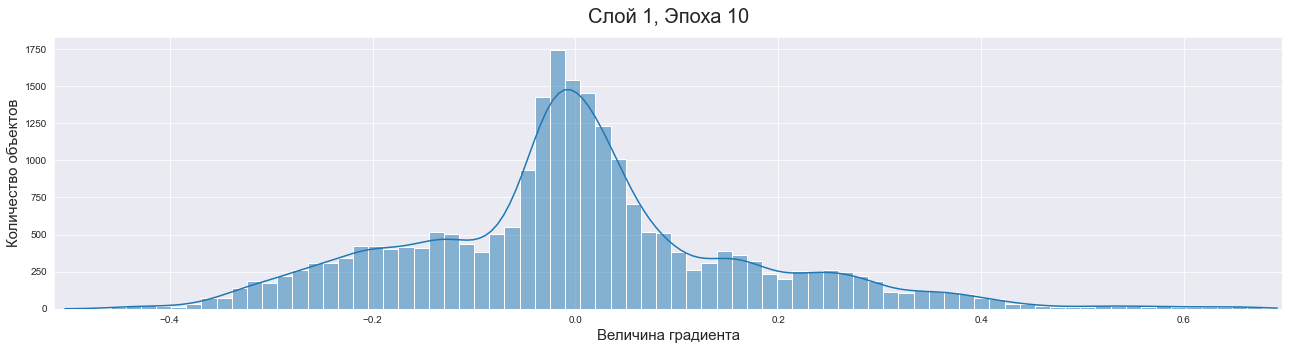

In [10]:
# Глубина 1

grads, train_loss, test_loss, train_acc, test_acc = get_info("depth_1_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.558, Test loss - 0.946
Train accuracy - 0.838, Test accuracy - 0.720



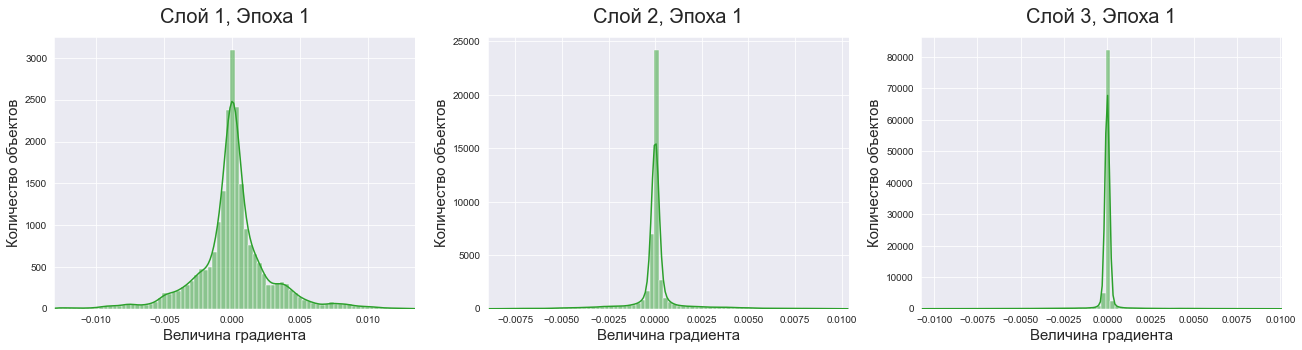

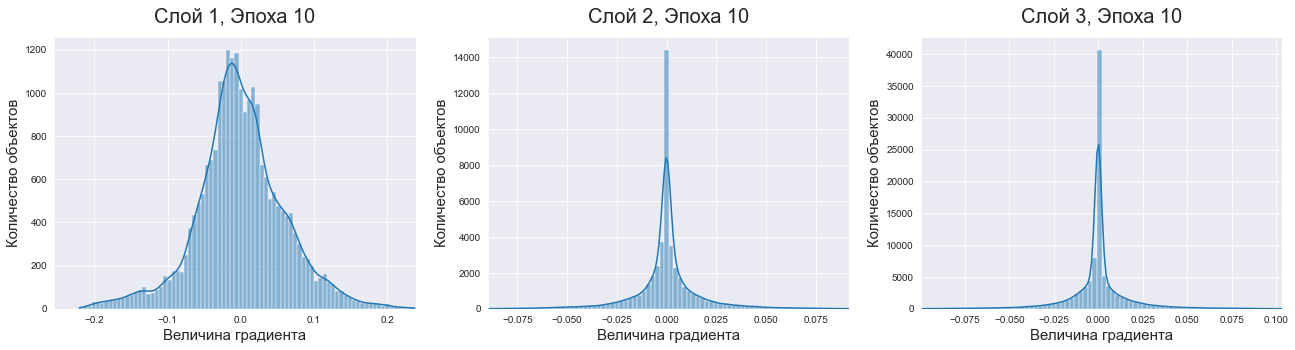

In [11]:
# Глубина 3

grads, train_loss, test_loss, train_acc, test_acc = get_info("depth_3_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.466, Test loss - 0.659
Train accuracy - 0.864, Test accuracy - 0.816



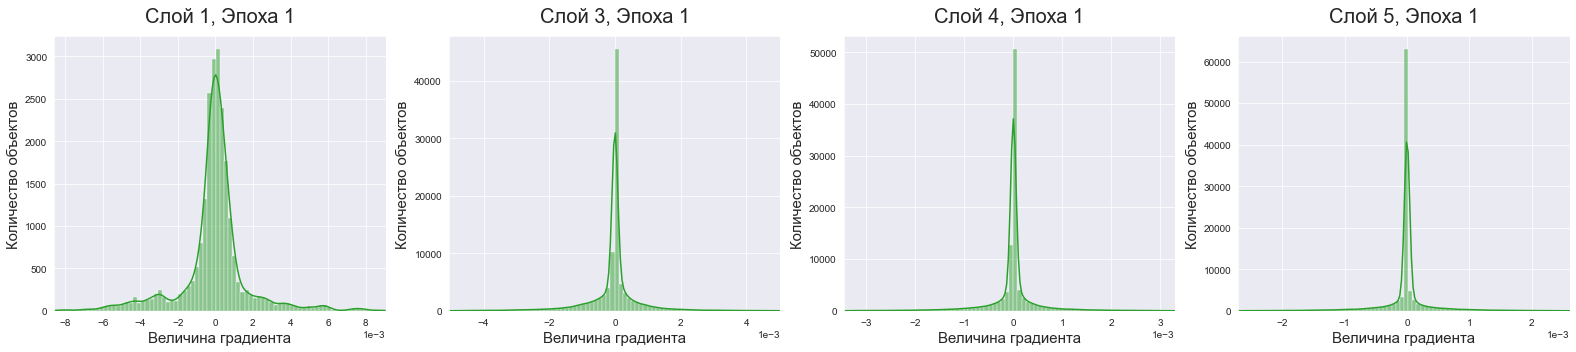

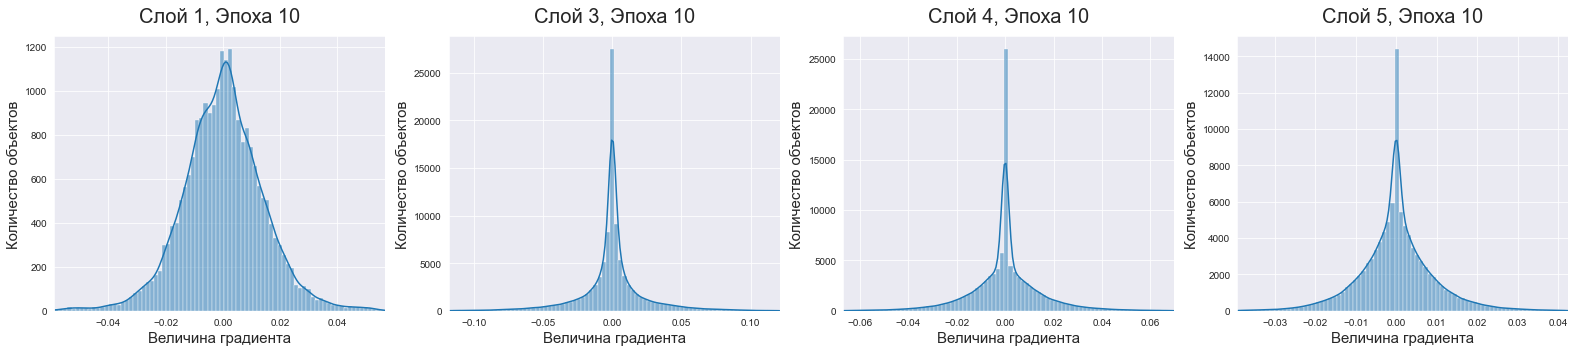

In [12]:
# Глубина 5

grads, train_loss, test_loss, train_acc, test_acc = get_info("depth_5_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 2.237, Test loss - 2.224
Train accuracy - 0.189, Test accuracy - 0.196



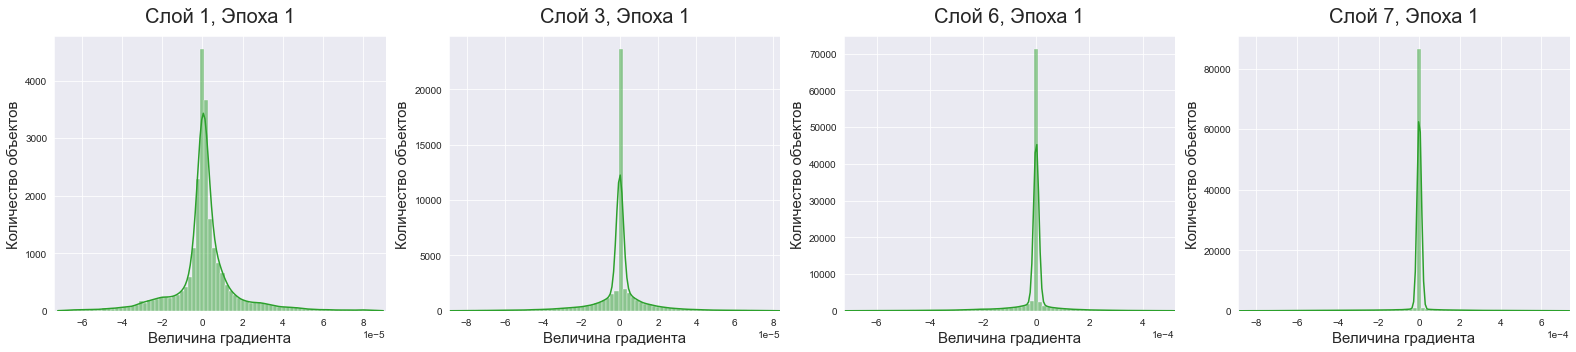

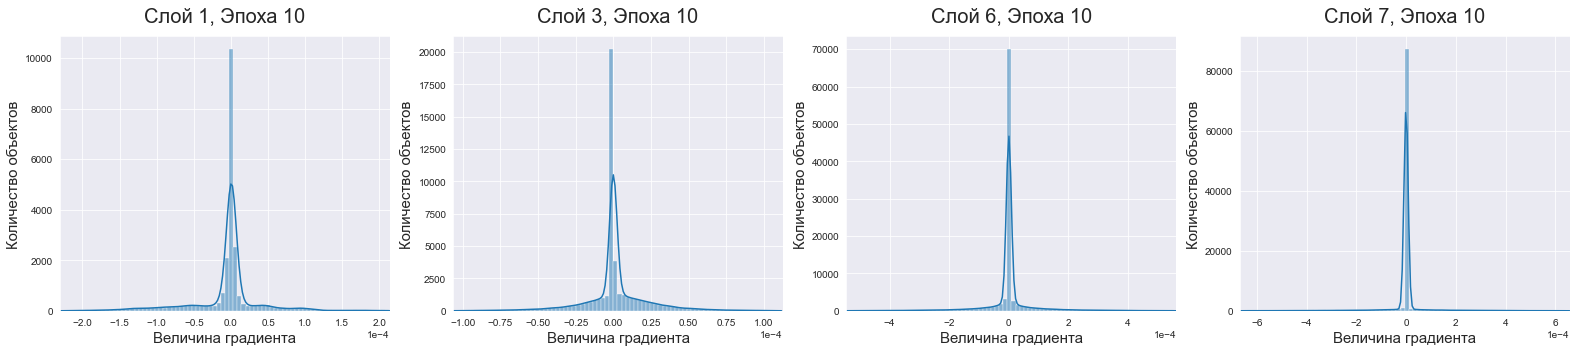

In [13]:
# Глубина 7

grads, train_loss, test_loss, train_acc, test_acc = get_info("depth_7_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 2.237, Test loss - 2.224
Train accuracy - 0.189, Test accuracy - 0.196



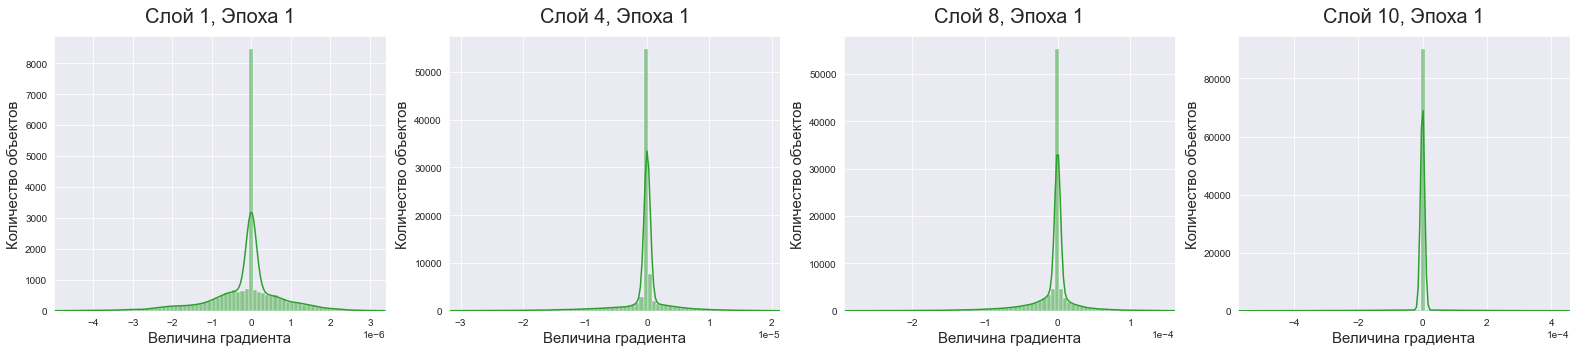

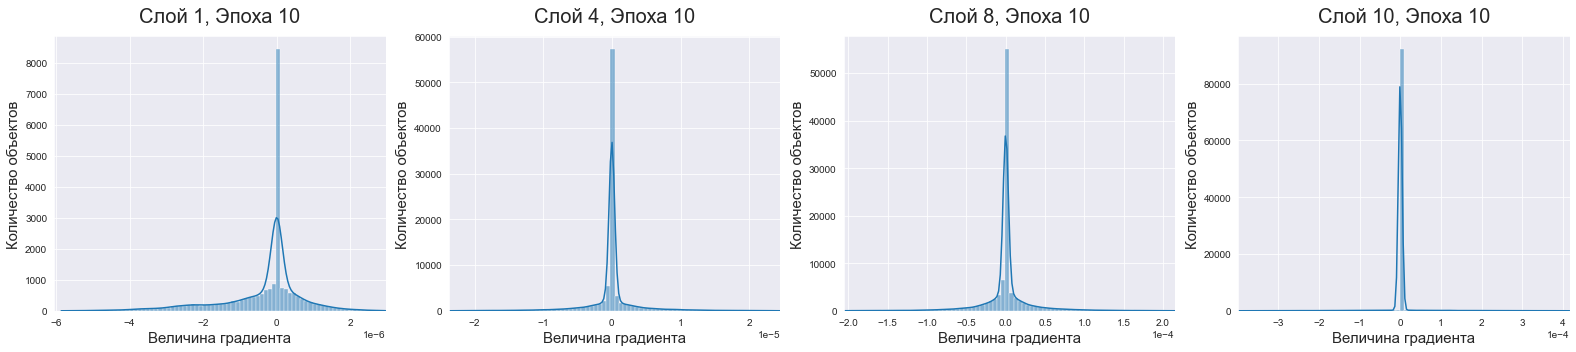

In [14]:
# Глубина 10

grads, train_loss, test_loss, train_acc, test_acc = get_info("depth_10_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Сразу заметим, что начиная с глубины 7 модели не удается обучиться. Также из распределений видно, что с ростом глубины сети на одинаковых (по глубине) слоях абсолютная величина градиента уменьшается. Также если рассматривать распределения градиентов для одной сети на разных слоях, то также можно заметить, что чем ближе слой к входному, тем меньше абсолютная величина градиентов. Таким образом, мы наблюдаем эффект ***затухания градиентов***. Именно поэтому при большом числе слоев сеть не может хорошо обучиться. Также стоит отметить, что распределения градиентов получаются довольно похожими на разных слоях, выделяется только самый первый слой. 

### Ширина

Для ширины рассмотрим следующие значения: 1.0, 1.4, 1.8, 2.6.

In [19]:
widths= [1.0, 1.4, 1.8, 2.6]
n_epochs = 10
loss_function = nn.NLLLoss()

for w in widths:
    model = CustomCNN(depth=5, width=w, skip=False, dropout=0.0, batchnorm=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'width_{w}', True, test_dataloader, True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss - 0.580, Test loss - 0.682
Train accuracy - 0.828, Test accuracy - 0.811



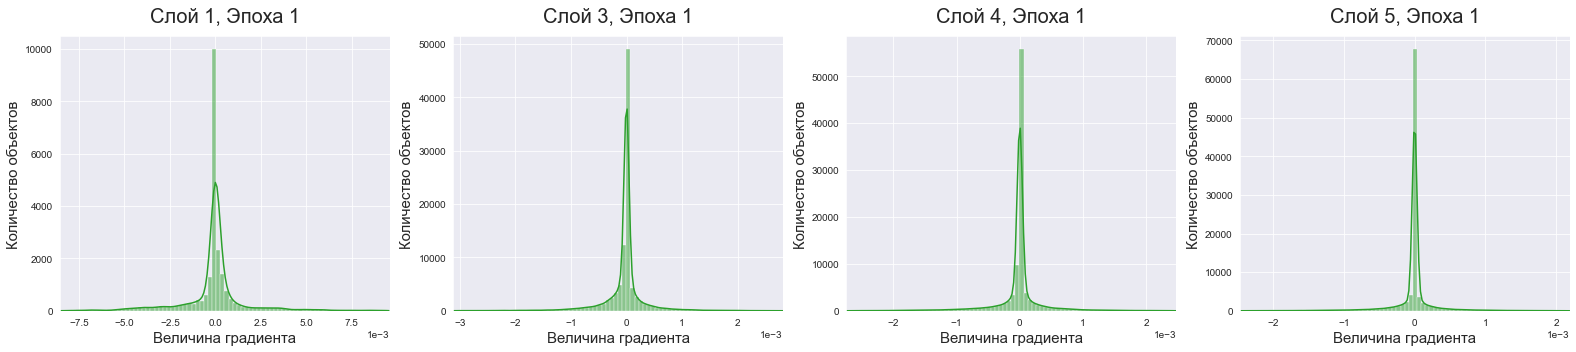

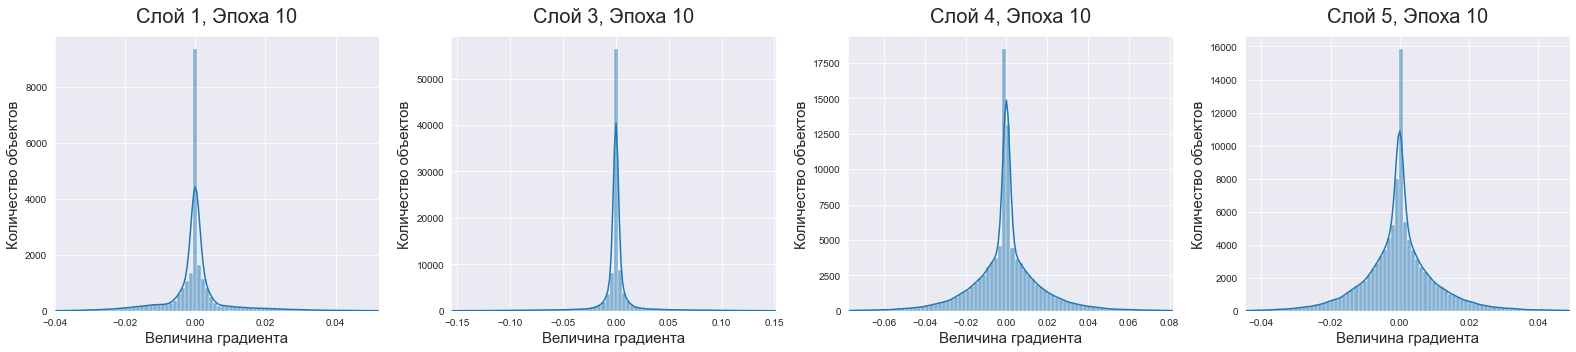

In [20]:
# Ширина 1.0

grads, train_loss, test_loss, train_acc, test_acc = get_info("width_1.0_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.390, Test loss - 0.778
Train accuracy - 0.887, Test accuracy - 0.770



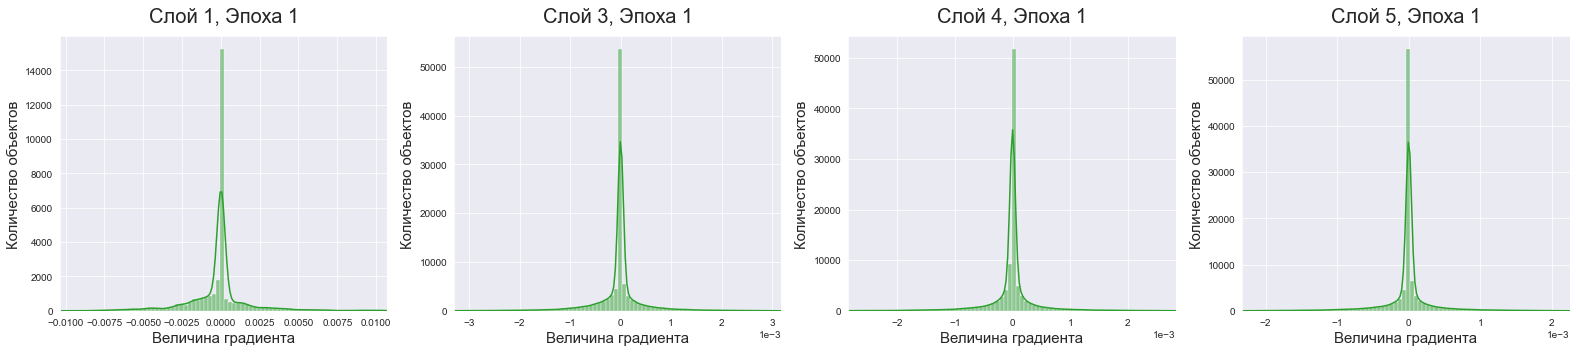

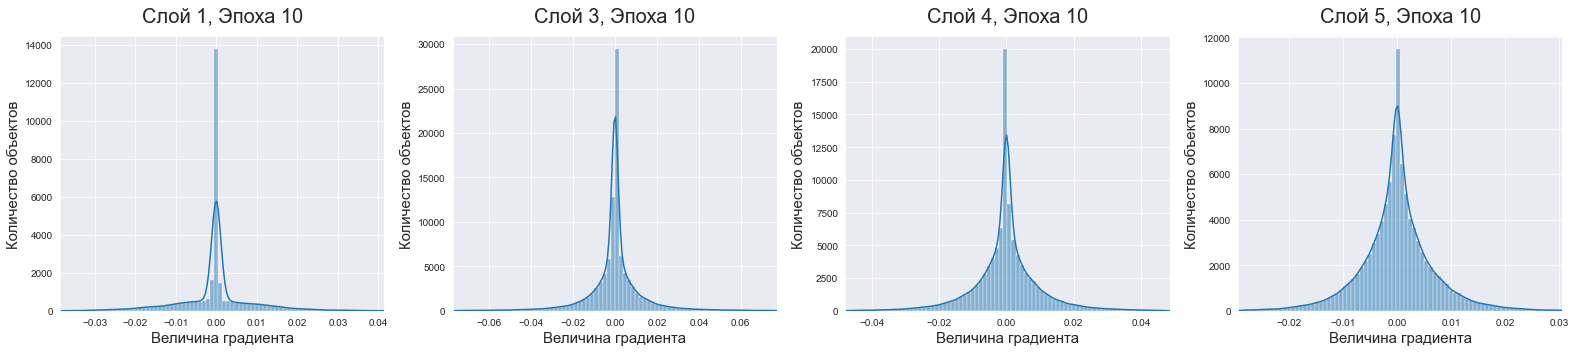

In [21]:
# Ширина 1.4

grads, train_loss, test_loss, train_acc, test_acc = get_info("width_1.4_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.387, Test loss - 0.973
Train accuracy - 0.887, Test accuracy - 0.690



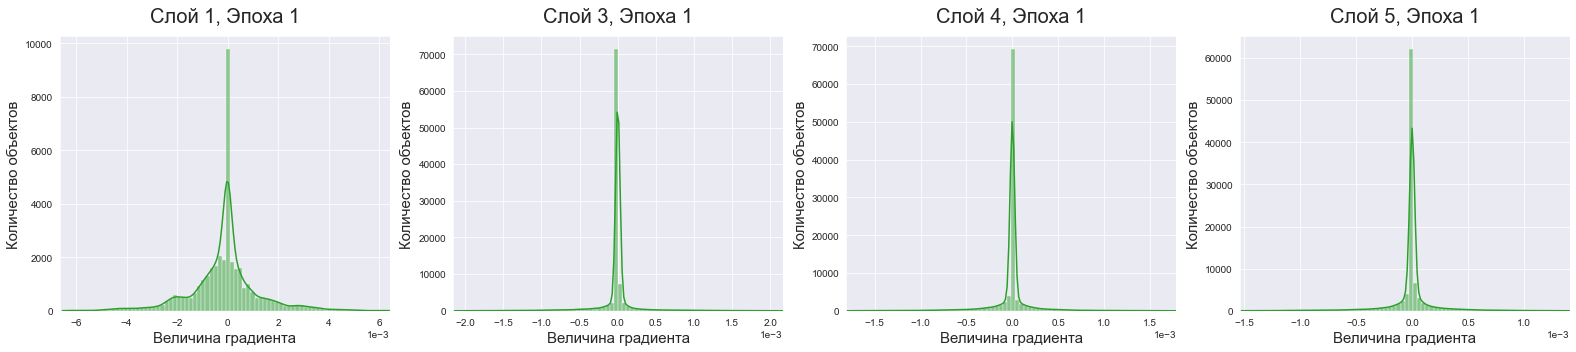

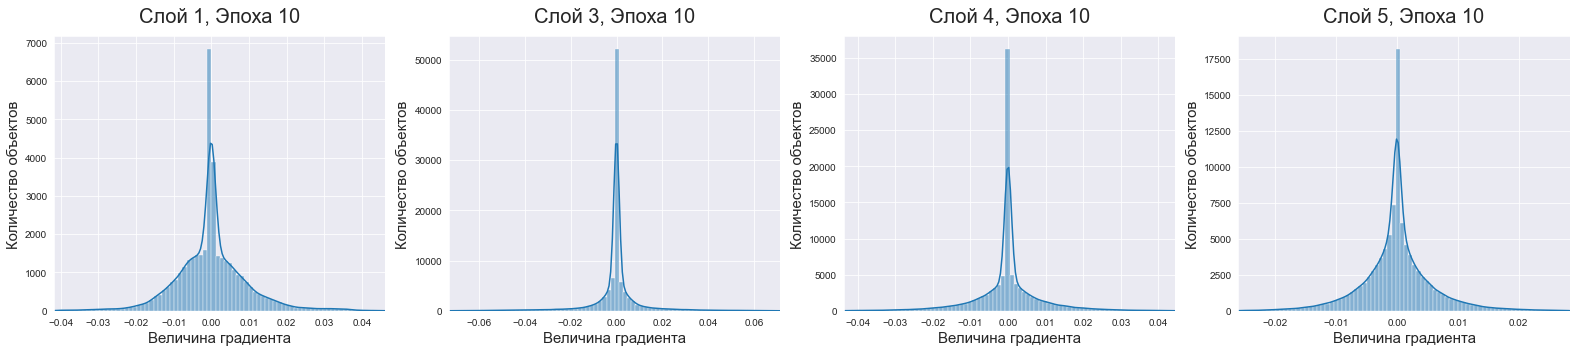

In [22]:
# Ширина 1.8

grads, train_loss, test_loss, train_acc, test_acc = get_info("width_1.8_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.355, Test loss - 0.821
Train accuracy - 0.895, Test accuracy - 0.744



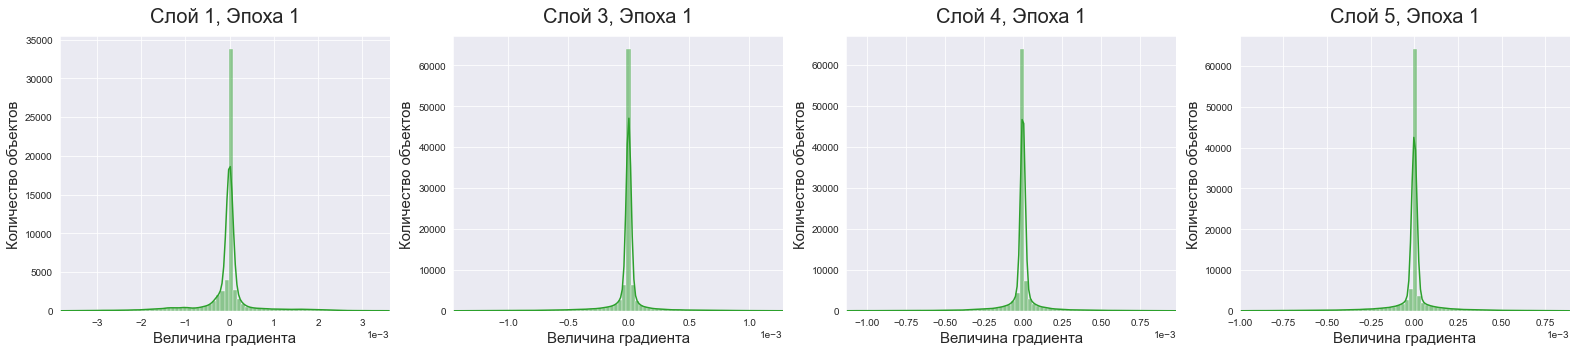

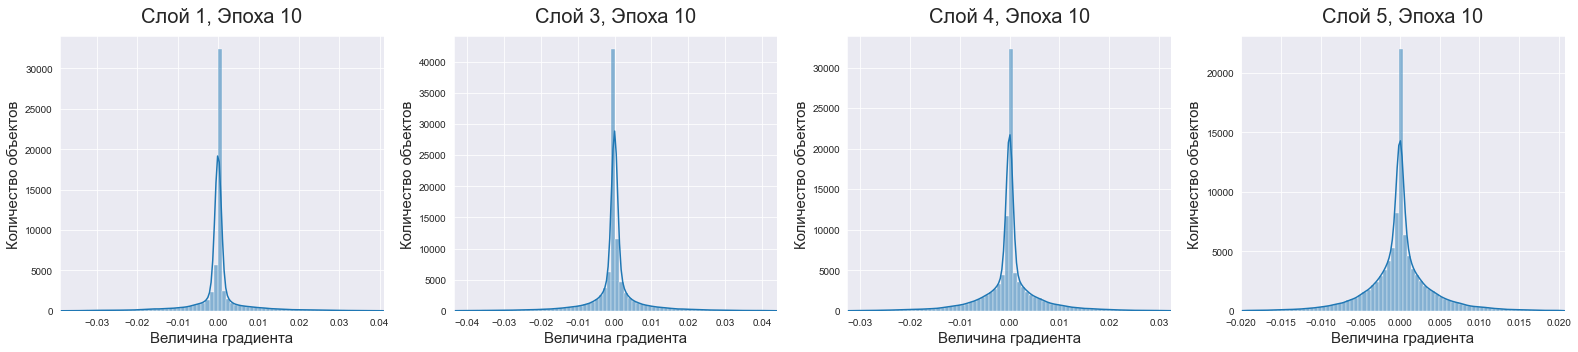

In [23]:
# Ширина 2.6

grads, train_loss, test_loss, train_acc, test_acc = get_info("width_2.6_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Очевидной закономерности изменения распределений градиентов при варьировании ширины обнаружить не удалось, однако можно отметить, что с ростом ширины сети точность на обучающем множетстве возрастает, а на тестовом уменьшается, что говорит о том, что сеть начинает сильнее переобучаться.

### Skip-connection

Чтобы использовать skip-connection рассмотрим достаточно глубокую сеть (необходимо, чтобы в серии блоков с одинаковым числом каналов было как минимум 2 блока, для реализации skip-connection), например глубины 10. Как мы могли наблюдать в предыдущих экспериментах, такая сеть без skip-connection не обучается из-за затухания градиентов.

In [25]:
skip_status = [False, True]
n_epochs = 10
loss_function = nn.NLLLoss()

for skip in skip_status:
    model = CustomCNN(depth=10, width=1.0, skip=skip, dropout=0.0, batchnorm=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'skip_{skip}', True, test_dataloader, True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss - 2.237, Test loss - 2.225
Train accuracy - 0.189, Test accuracy - 0.196



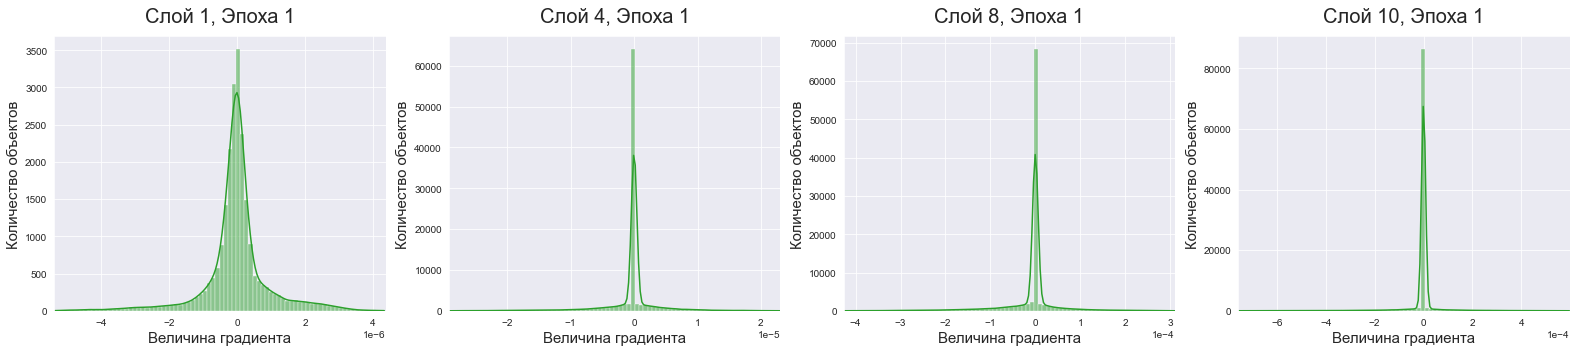

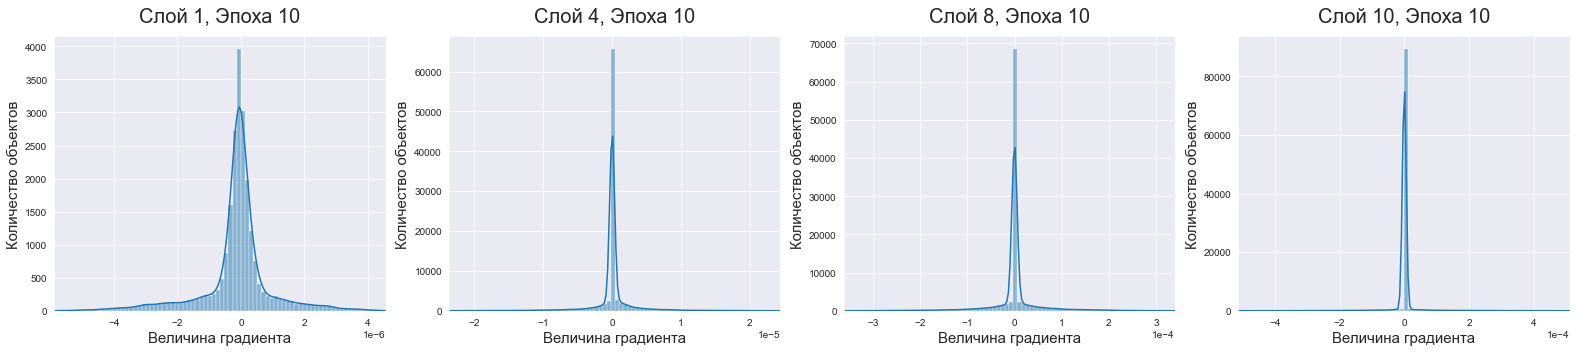

In [26]:
# Без использования skip-connection

grads, train_loss, test_loss, train_acc, test_acc = get_info("skip_False_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.429, Test loss - 0.912
Train accuracy - 0.871, Test accuracy - 0.729



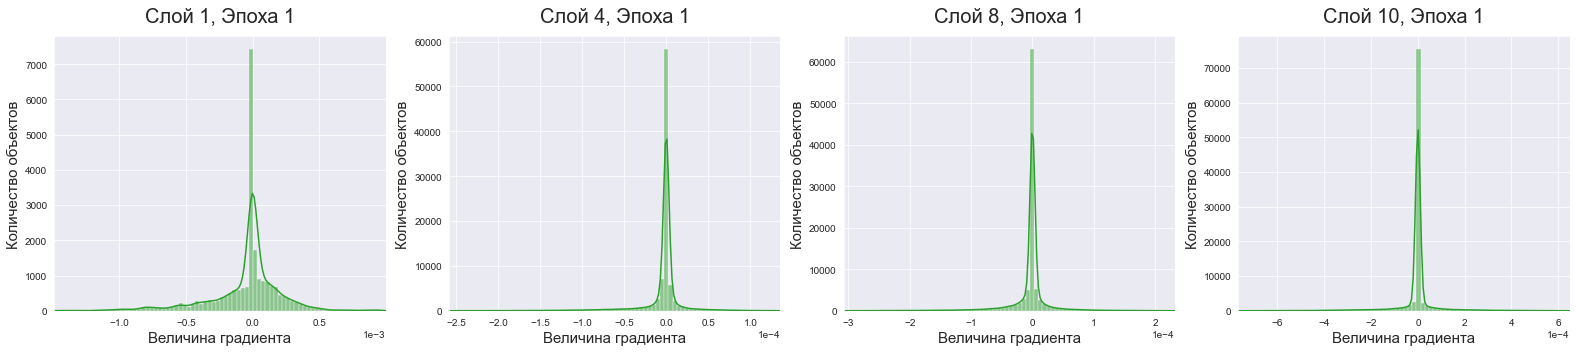

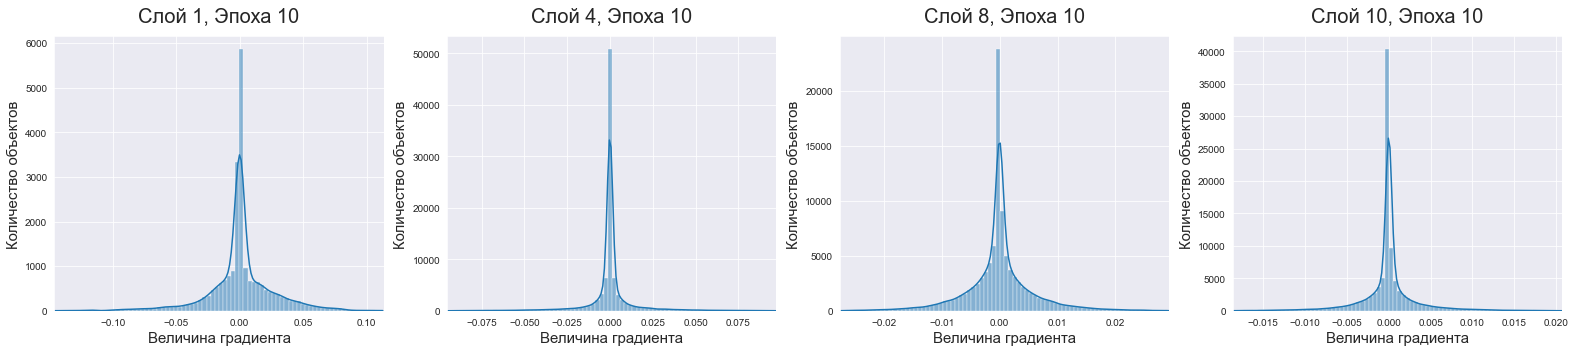

In [27]:
# С использованием skip-connection

grads, train_loss, test_loss, train_acc, test_acc = get_info("skip_True_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Как мы видим, использование skip-connection позволяет справиться с проблемой затухания градиентов, сеть успешно обучается. Абсолютные значение градиентов перестают так драматично уменьшаться при движении от последнего слоя к первому, как это происходило без использоания skip-connection.

### BatchNorm

In [31]:
bn_status = [False, True]
n_epochs = 10
loss_function = nn.NLLLoss()

for bn in bn_status:
    model = CustomCNN(depth=5, width=1.0, skip=False, dropout=0.0, batchnorm=bn)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'bn_{bn}', True, test_dataloader, True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss - 0.501, Test loss - 0.734
Train accuracy - 0.850, Test accuracy - 0.793



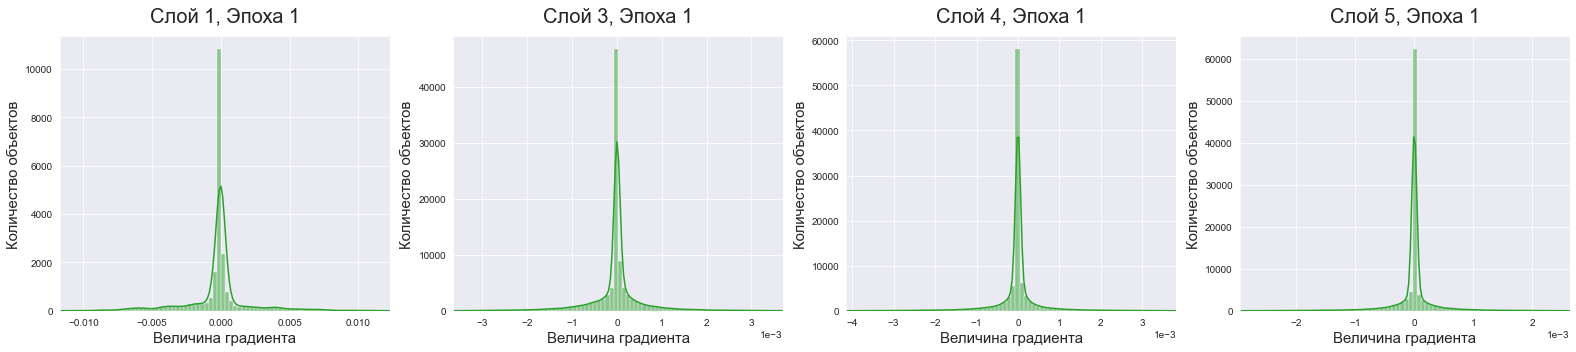

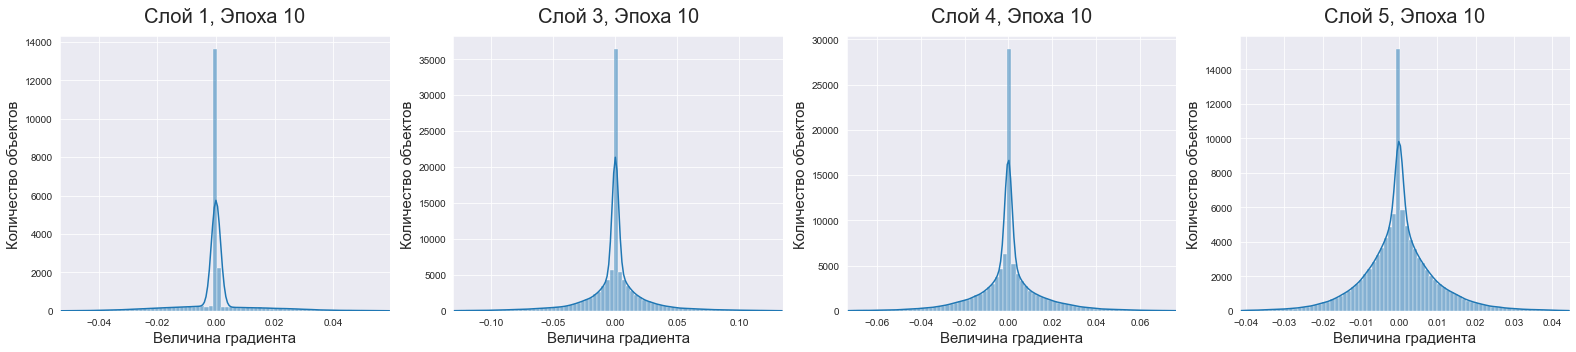

In [32]:
# Без использования батч-нормализации

grads, train_loss, test_loss, train_acc, test_acc = get_info("bn_False_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.260, Test loss - 0.409
Train accuracy - 0.923, Test accuracy - 0.880



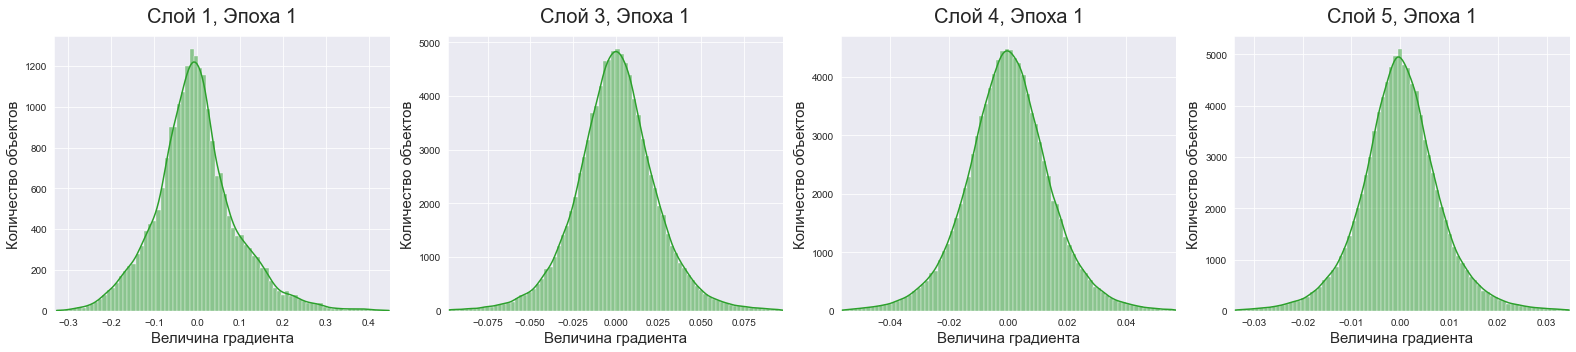

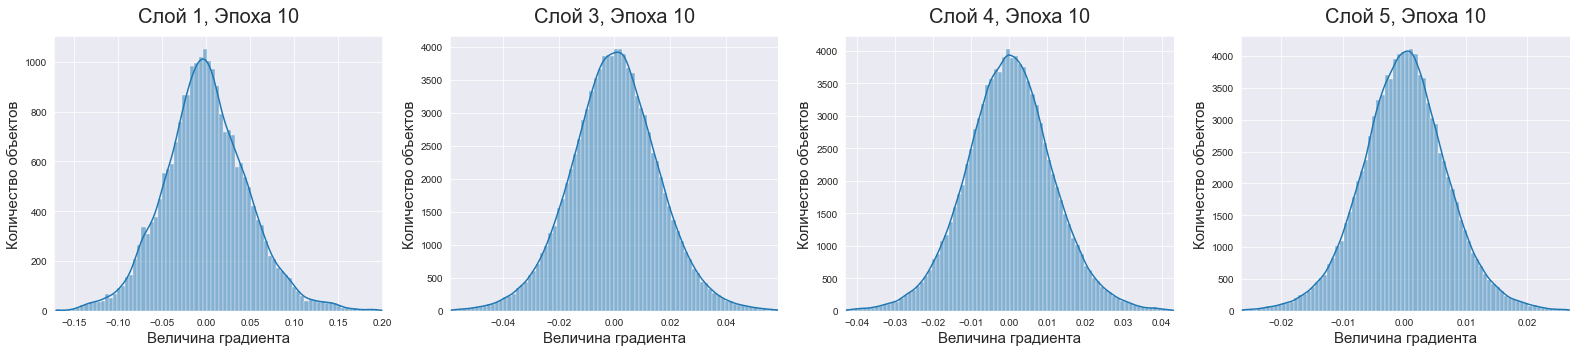

In [33]:
# С использованием батч-нормализации

grads, train_loss, test_loss, train_acc, test_acc = get_info("bn_True_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Эффект от использования батч-нормализации очень легко заметить. Распределения градиентов по слоям принимают теперь совершенно другой вид, при этом для разных слоев форма распределения градиентов одна и та же. При использовании батч-нормализации наблюдается существенный прирост в точности как на обучающем, так и тестовом множествах: на обучающем на  0.073, а на тестовом на 0.87.

### Dropout

Теперь попробуем использовать дропаут в нашей сети. Рассмотрим следующие значения параметра `p` в дропауте: 0.0, 0.1, 0.2, 0.3. При использовании дропаута часто приходится дольше обучать сеть, поэтому увеличим число эпох с 10 до 20.

In [111]:
do_prob = [0.0, 0.1, 0.2, 0.3]
n_epochs = 20
loss_function = nn.NLLLoss()

for p in do_prob:
    model = CustomCNN(depth=5, width=1.0, skip=False, dropout=p, batchnorm=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'do_{p}', True, test_dataloader, True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss - 0.319, Test loss - 0.539
Train accuracy - 0.905, Test accuracy - 0.843



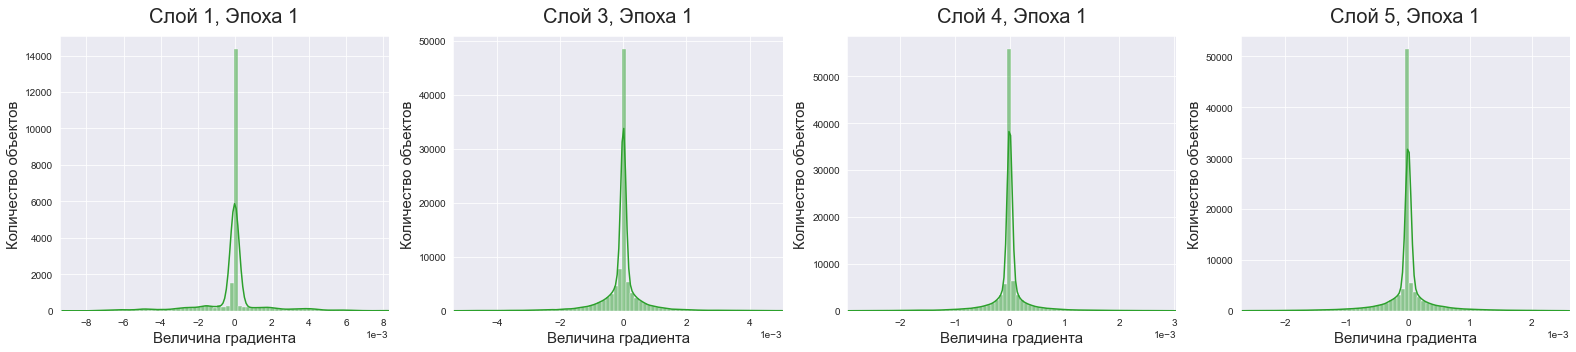

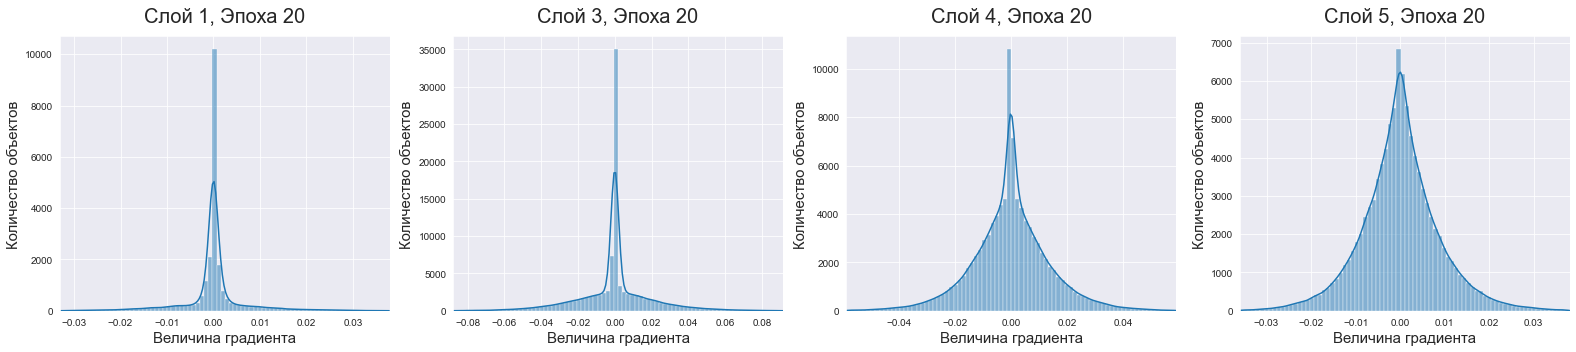

In [116]:
# p = 0.0

grads, train_loss, test_loss, train_acc, test_acc = get_info("do_0.0_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 19, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.492, Test loss - 0.698
Train accuracy - 0.848, Test accuracy - 0.789



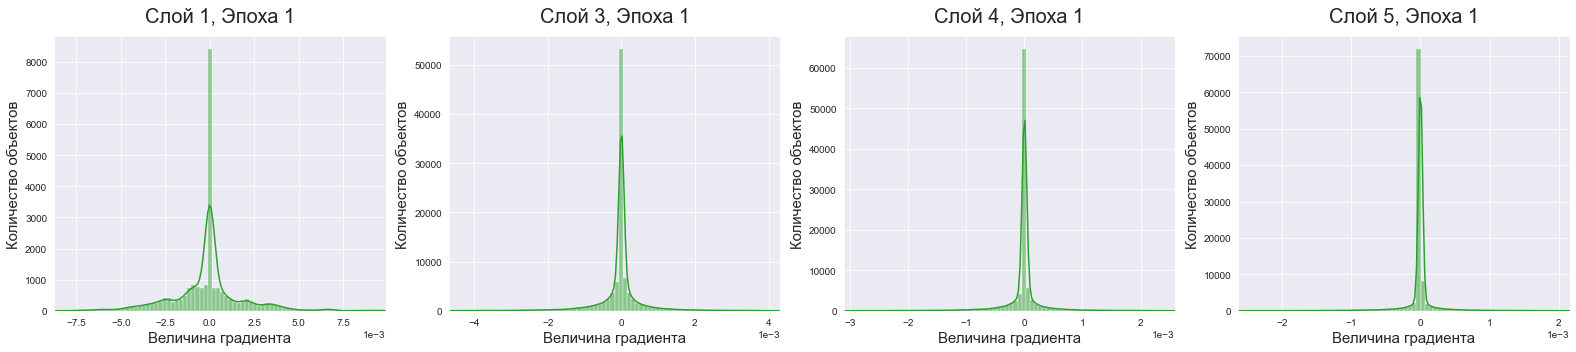

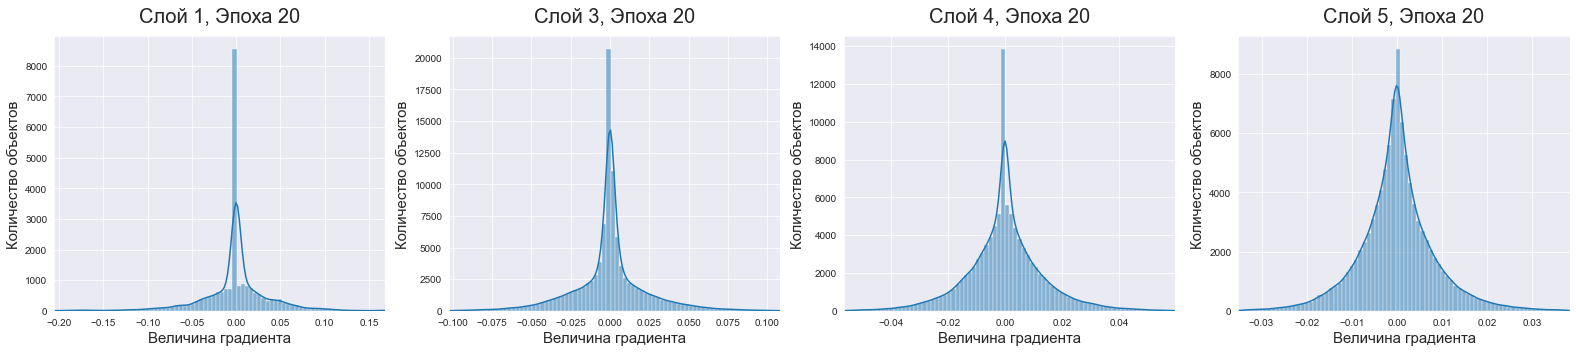

In [117]:
# p = 0.1

grads, train_loss, test_loss, train_acc, test_acc = get_info("do_0.1_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 19, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.569, Test loss - 0.651
Train accuracy - 0.822, Test accuracy - 0.803



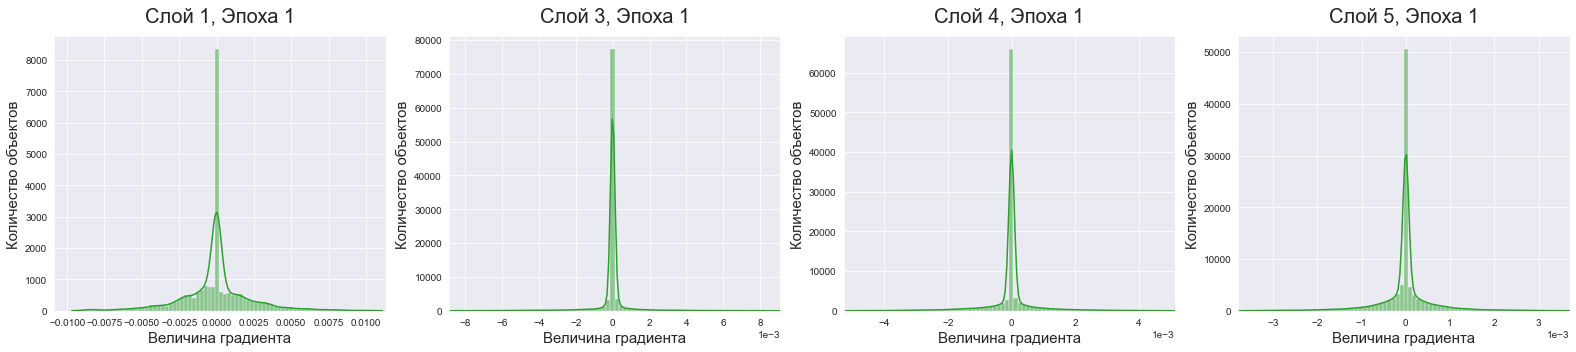

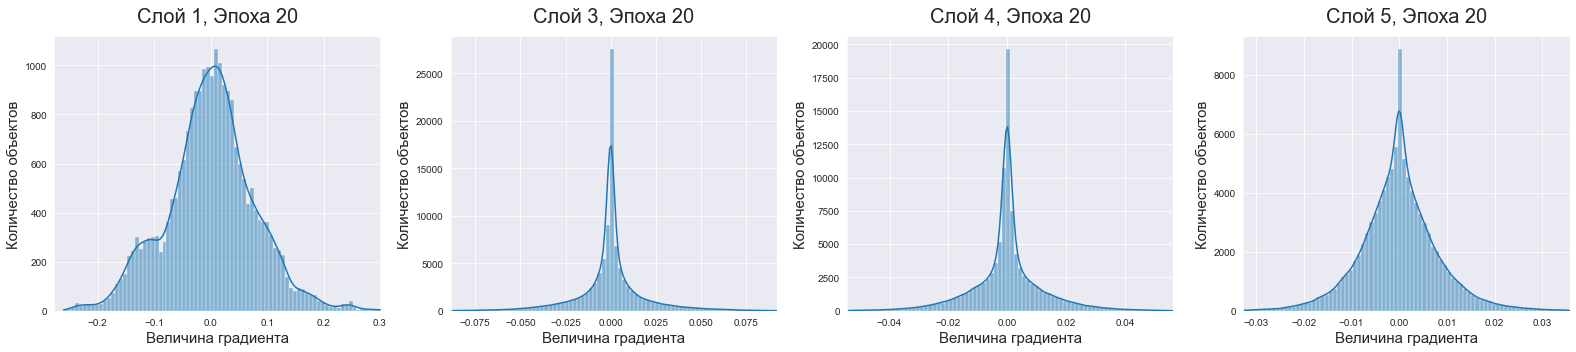

In [118]:
# p = 0.2

grads, train_loss, test_loss, train_acc, test_acc = get_info("do_0.2_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 19, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.650, Test loss - 0.814
Train accuracy - 0.793, Test accuracy - 0.736



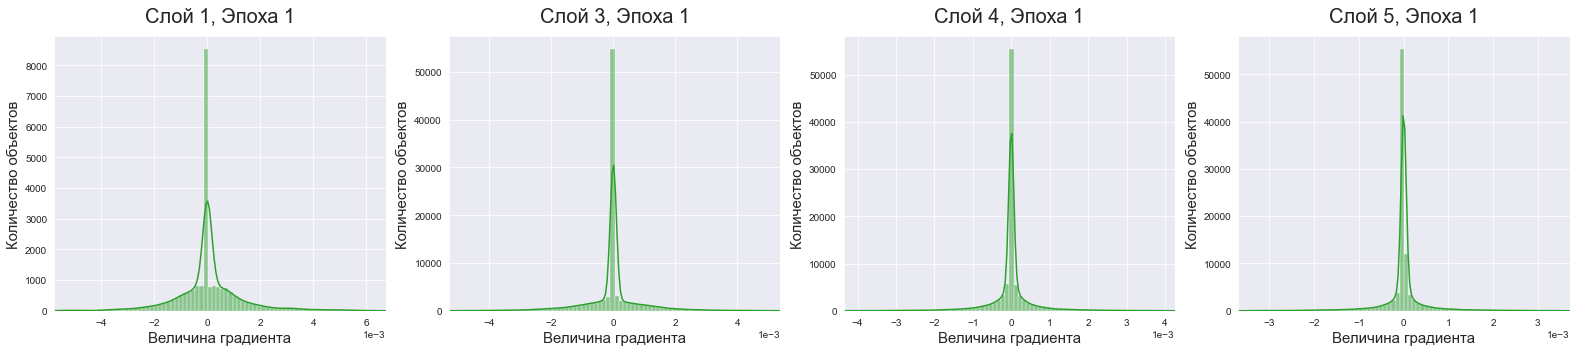

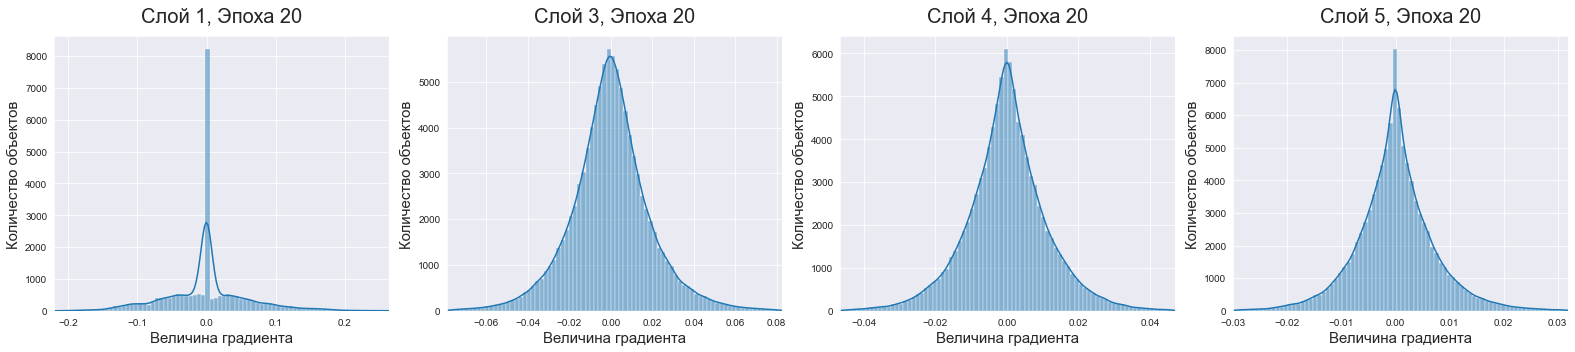

In [119]:
# p = 0.3

grads, train_loss, test_loss, train_acc, test_acc = get_info("do_0.3_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 19, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Использование дропаута не дало прироста в качестве, однако распределения градиентов в некоторых случаях сильно изменились.

### Инициализация весов

Кроме инициализации весов, которая используется в PyTorch по умолчанию, рассмотрим следующие способы инициализации:

* Инициализация нулями
* Kaiming uniform
* Kaiming normal
* Xavier uniform
* Xavier normal


In [10]:
init_types = ["zeros", "kaiming_uniform", "kaiming_normal", "xavier_uniform", "xavier_normal"]
n_epochs = 10
loss_function = nn.NLLLoss()

for init in init_types:
    model = CustomCNN(depth=5, width=1.0, skip=False, dropout=0.0, batchnorm=False)
    init_conv_layers(model, init=init)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'init_{init}', True, test_dataloader, True)
    


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss - 2.237, Test loss - 2.225
Train accuracy - 0.189, Test accuracy - 0.196



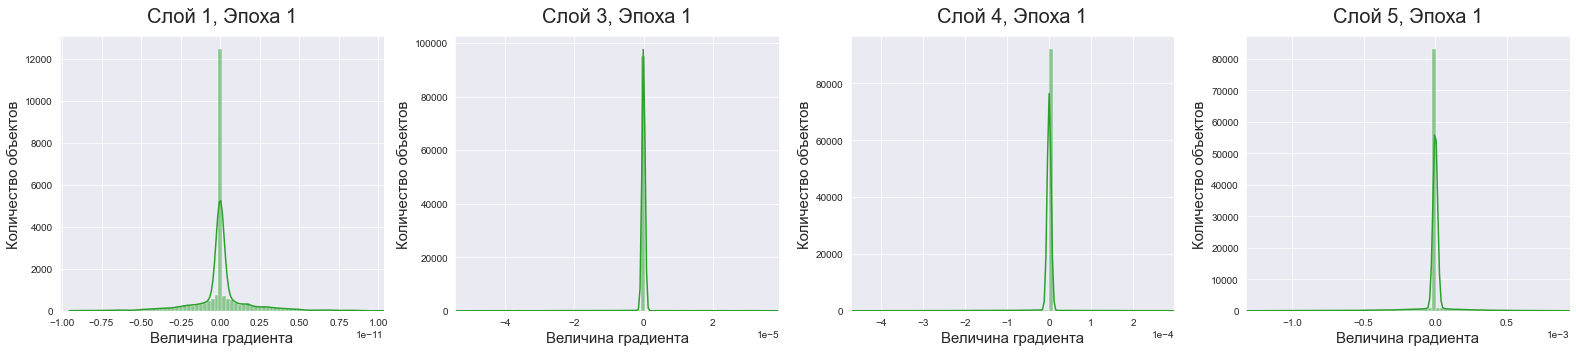

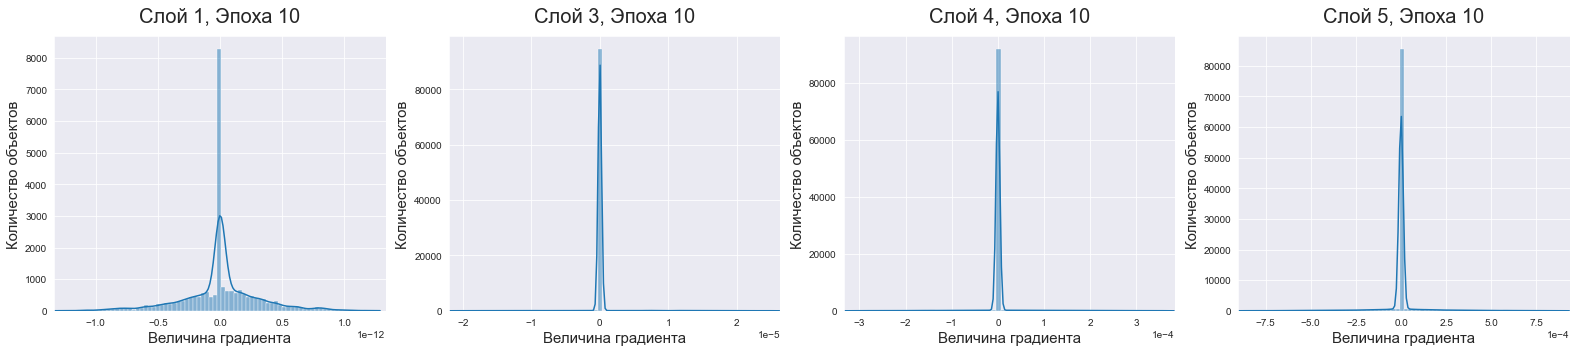

In [11]:
# zeros initialization

grads, train_loss, test_loss, train_acc, test_acc = get_info("init_zeros_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.488, Test loss - 0.923
Train accuracy - 0.851, Test accuracy - 0.709



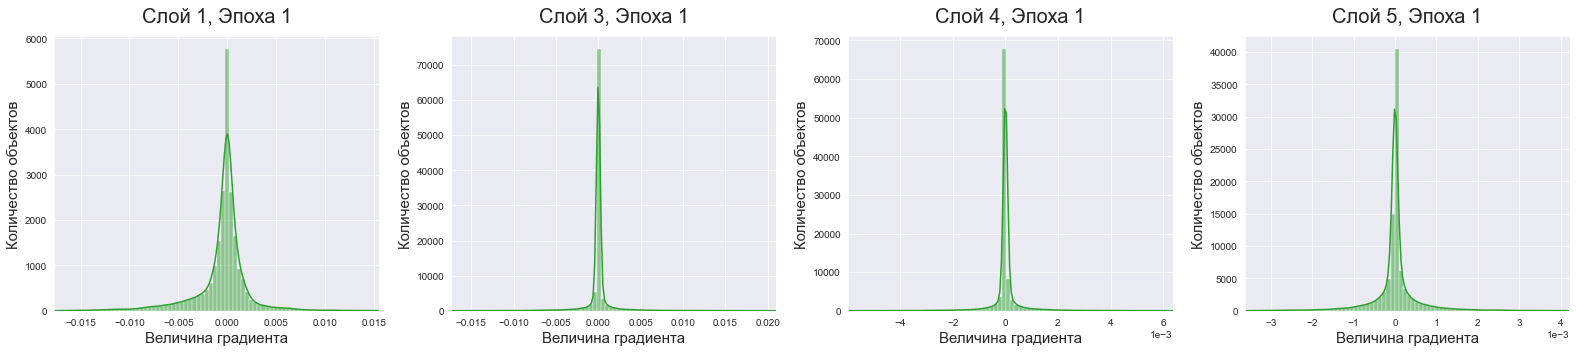

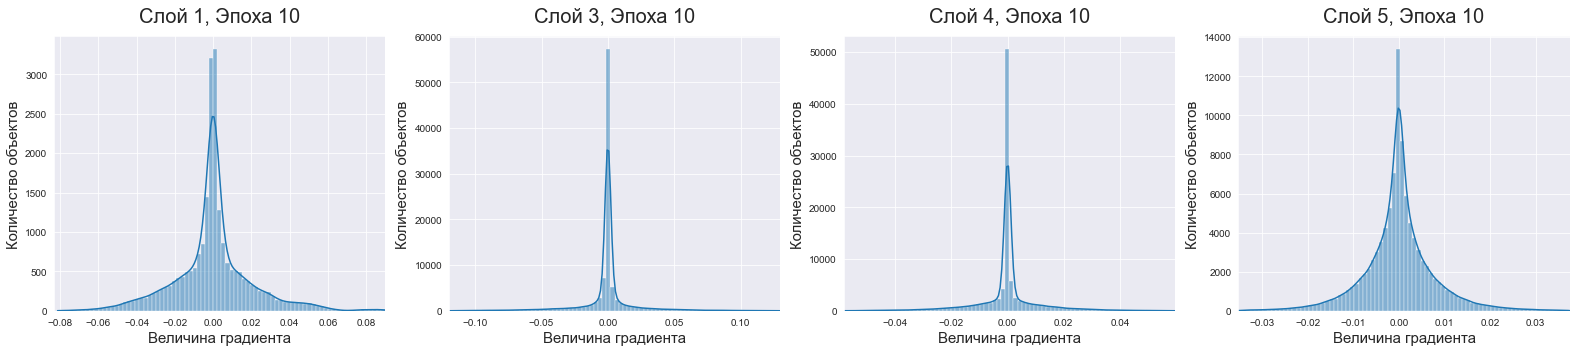

In [12]:
# Kaiming uniform initialization

grads, train_loss, test_loss, train_acc, test_acc = get_info("init_kaiming_uniform_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.483, Test loss - 0.814
Train accuracy - 0.851, Test accuracy - 0.752



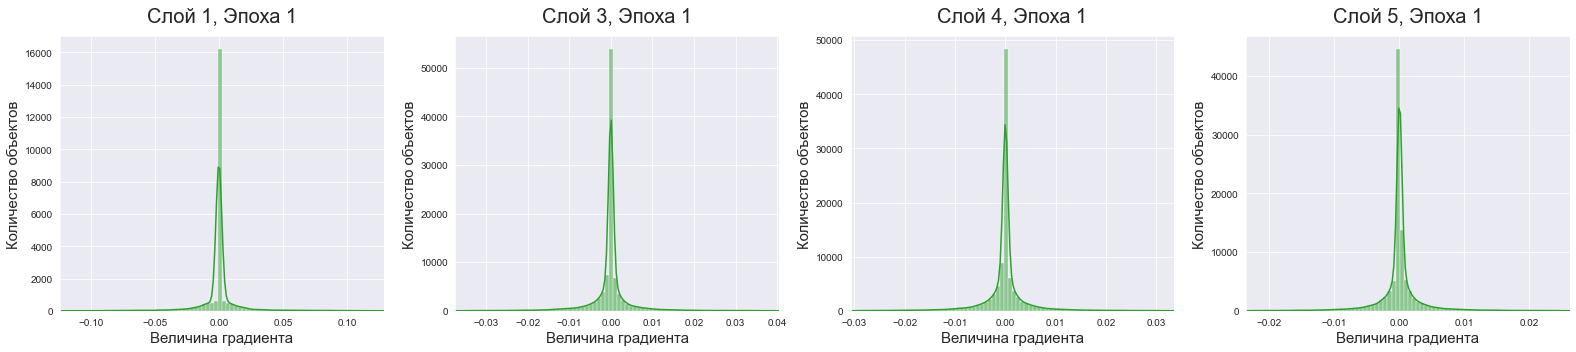

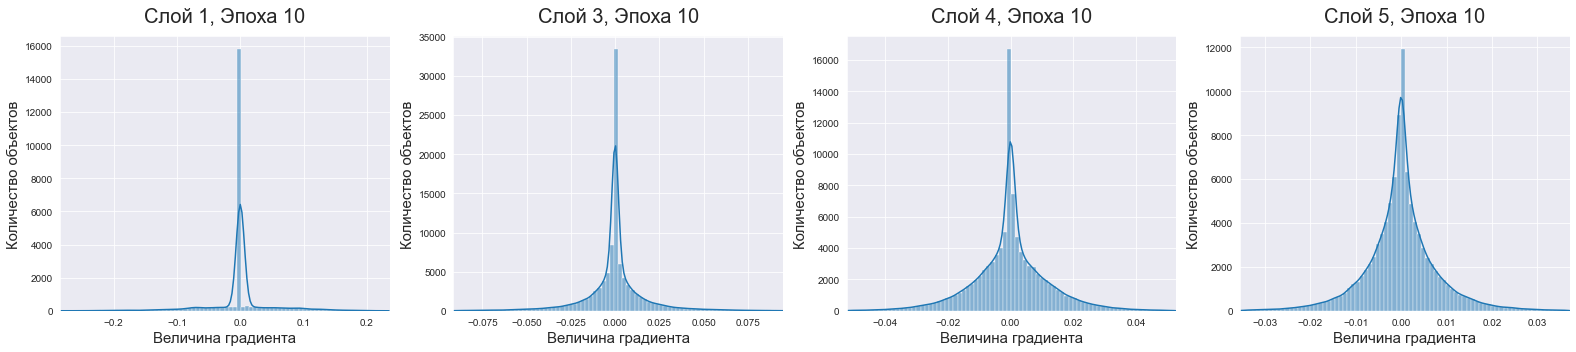

In [13]:
# Kaiming normal initialization

grads, train_loss, test_loss, train_acc, test_acc = get_info("init_kaiming_normal_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.420, Test loss - 0.581
Train accuracy - 0.875, Test accuracy - 0.839



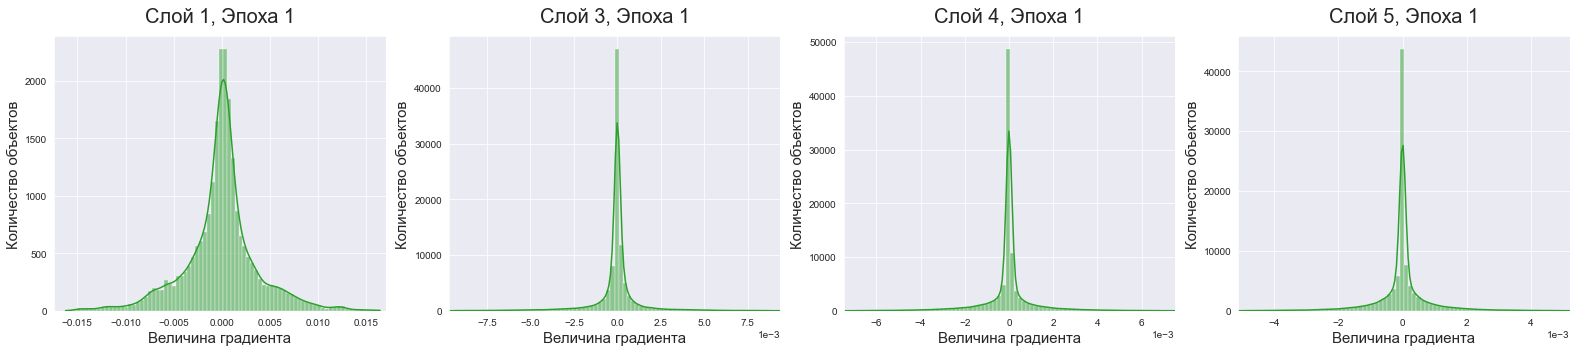

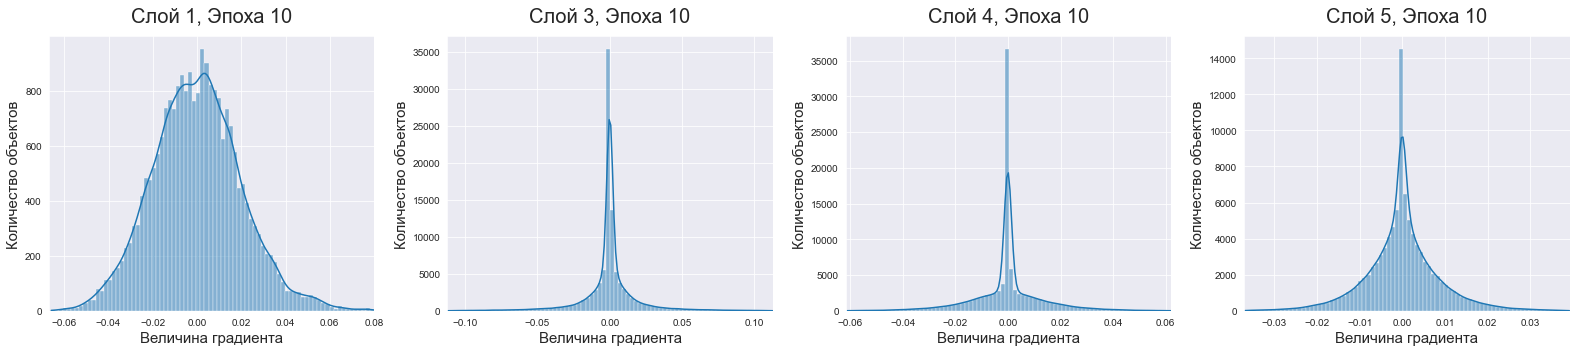

In [14]:
# Xavier uniform initialization

grads, train_loss, test_loss, train_acc, test_acc = get_info("init_xavier_uniform_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.401, Test loss - 0.627
Train accuracy - 0.879, Test accuracy - 0.810



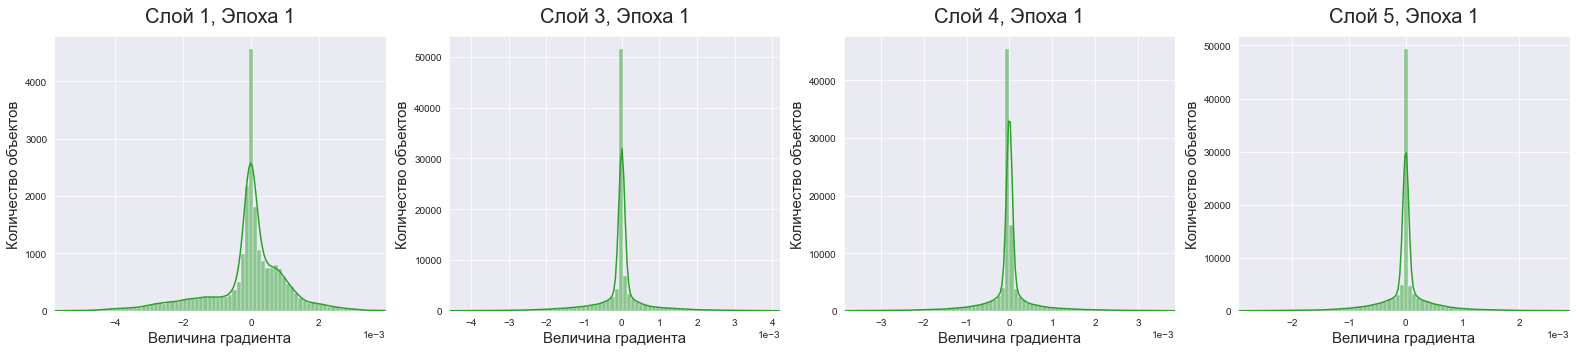

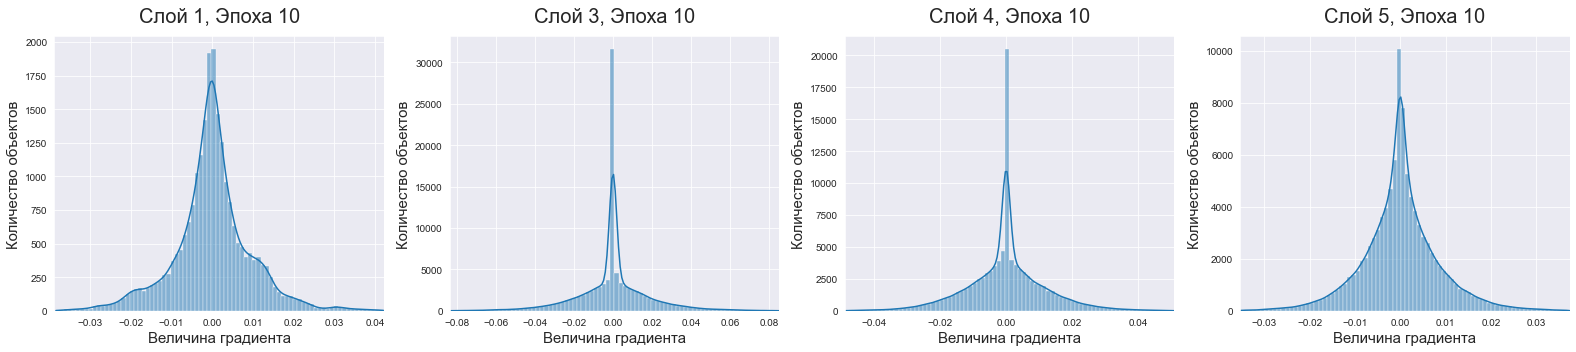

In [15]:
# Xavier normal initialization

grads, train_loss, test_loss, train_acc, test_acc = get_info("init_xavier_normal_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

При инициализации нулями сеть обучиться не смогла, градиенты получались везде близкие к нулю. Использование разных инициализация позволило достичь разного качества. Распределения градиентов также получились разными, однако выявить некие закономерности затруднительно.

### Оптимизатор

Ранее всегда использовался обычный SGD. Попробуем кроме него использовать следующие варианты оптимизаторов:

* Adam
* AdaMax

Перебирать параметры для каждого оптимизатора довольно долго и кажется не слишком полезным занятием. Поэтомутам где это возможно будем использовать значения по умолчанию.

In [22]:
optimizers = ["SGD", "Adam", "AdaMax"]
n_epochs = 10
loss_function = nn.NLLLoss()

for optim in optimizers:
    model = CustomCNN(depth=5, width=1.0, skip=False, dropout=0.0, batchnorm=False)
    if optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    elif optim == "Nesterov":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    elif optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optim == "AdaMax":
        optimizer = torch.optim.Adamax(model.parameters())
    train(model, train_dataloader, n_epochs, loss_function, optimizer, 'cuda', './', f'optim_{optim}', True, test_dataloader, True)
    


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss - 0.466, Test loss - 0.659
Train accuracy - 0.864, Test accuracy - 0.816



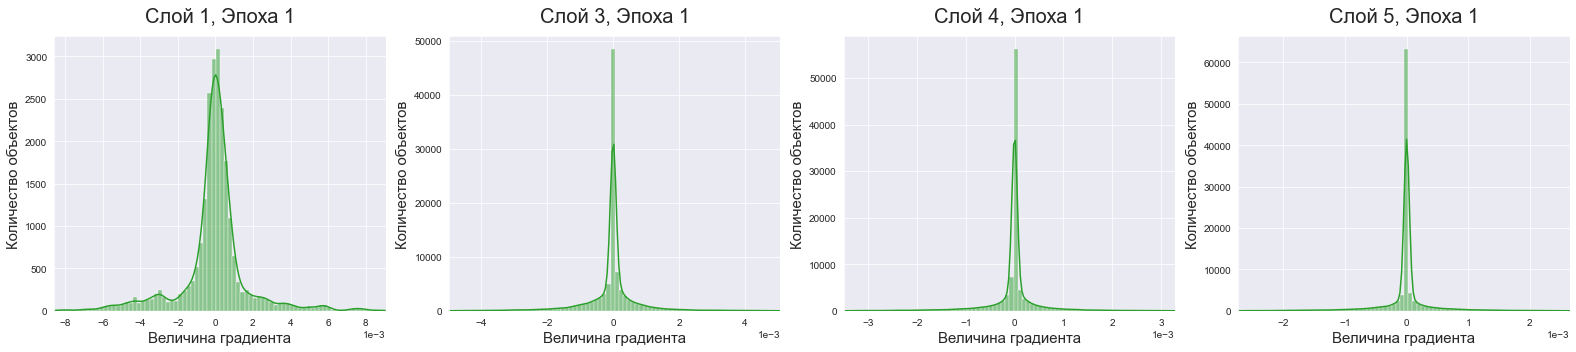

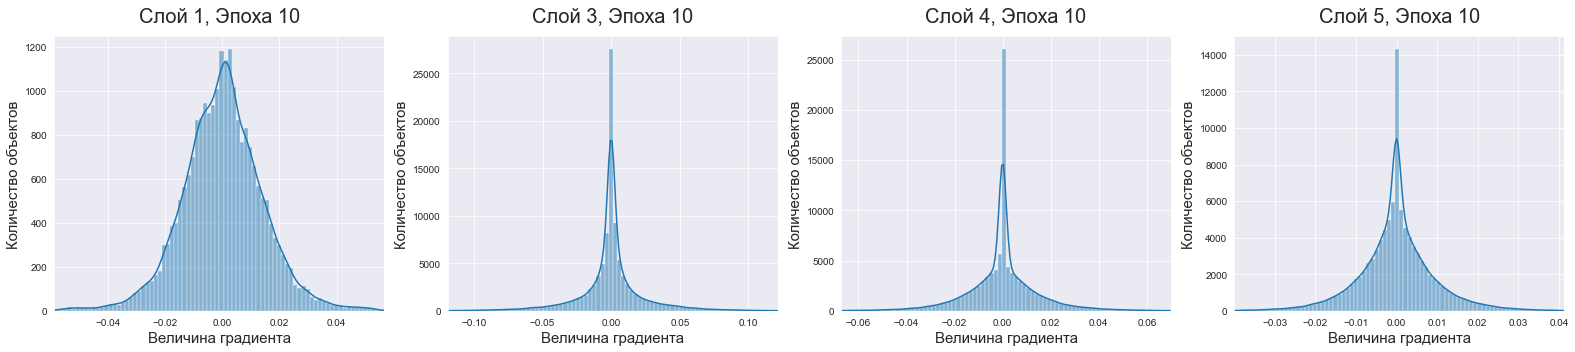

In [26]:
# SGD

grads, train_loss, test_loss, train_acc, test_acc = get_info("optim_SGD_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.414, Test loss - 0.471
Train accuracy - 0.876, Test accuracy - 0.867



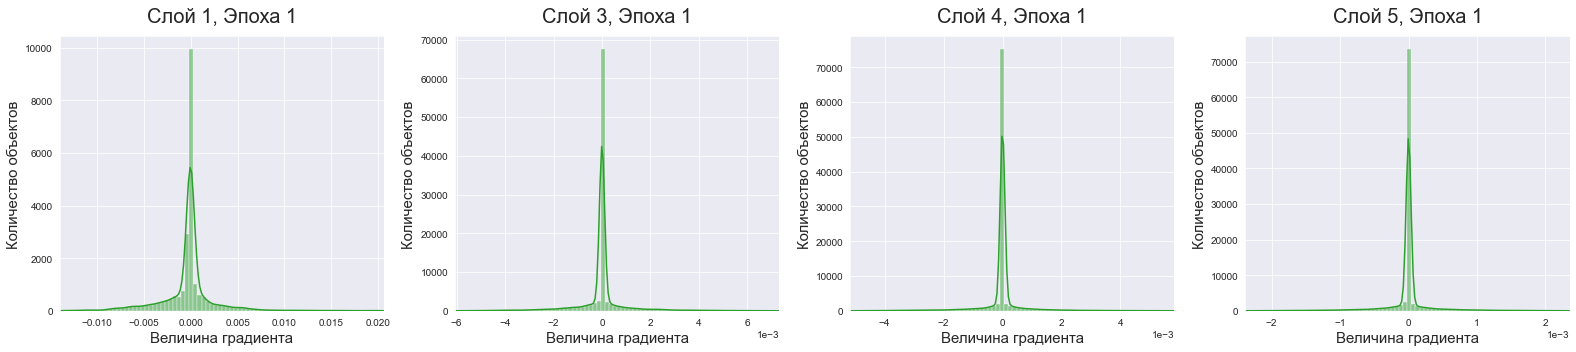

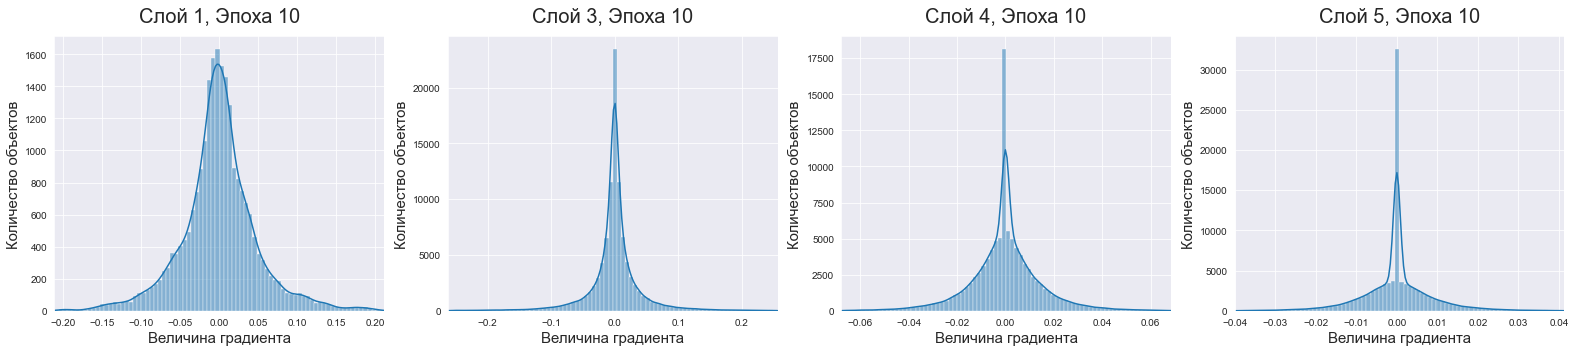

In [19]:
# Adam

grads, train_loss, test_loss, train_acc, test_acc = get_info("optim_Adam_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Train loss - 0.496, Test loss - 0.541
Train accuracy - 0.853, Test accuracy - 0.846



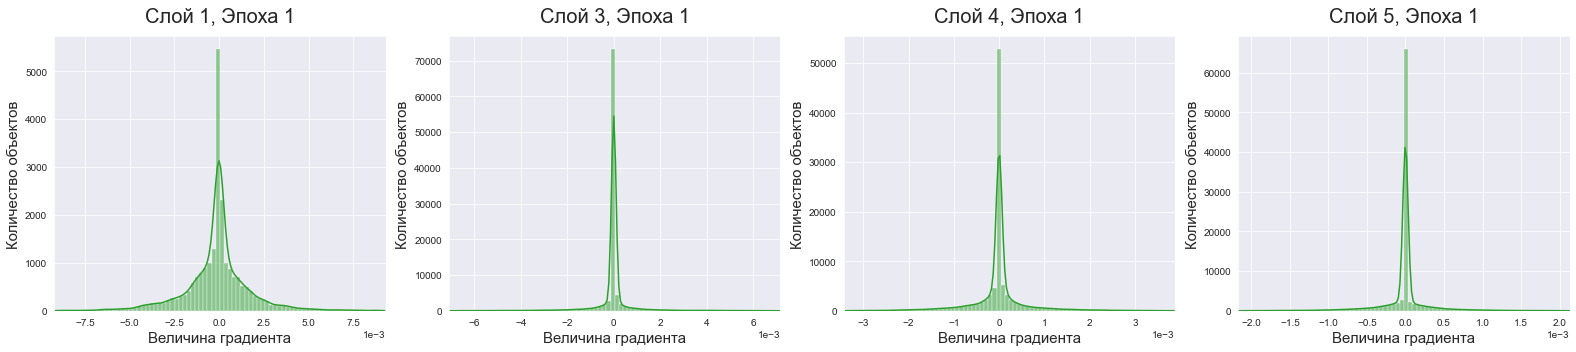

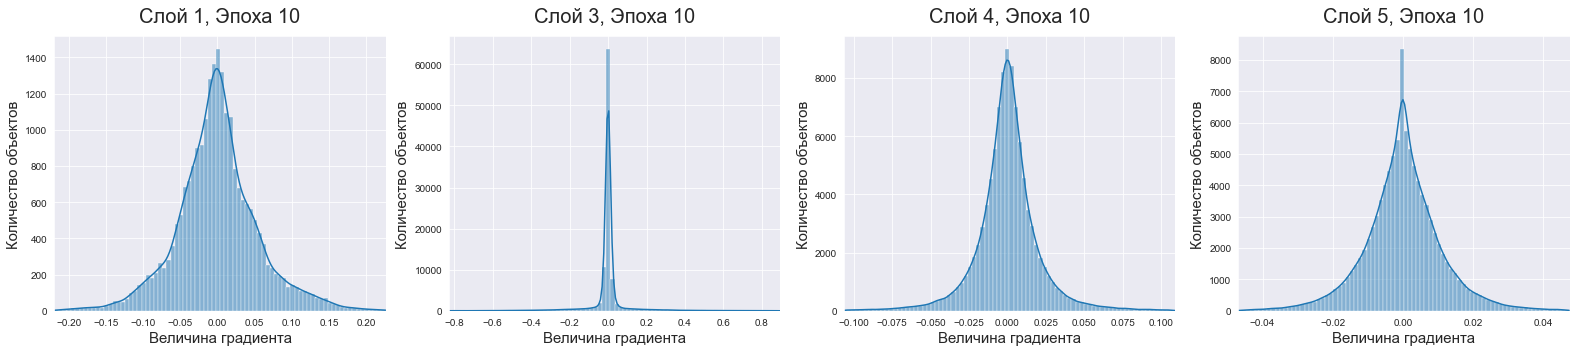

In [20]:
# AdaMax

grads, train_loss, test_loss, train_acc, test_acc = get_info("optim_AdaMax_history.dict")
show_layer_grads(grads, 0, sns.color_palette('tab10')[2])
show_layer_grads(grads, 9, sns.color_palette('tab10')[0])

print(f"Train loss - {train_loss:.3f}, Test loss - {test_loss:.3f}")
print(f"Train accuracy - {train_acc:.3f}, Test accuracy - {test_acc:.3f}\n")

Использование Adam позволило достичь наилучшего качества. Какие-то комментарии по поводу распределений дать затруднительно.